In [148]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [167]:
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [18]:
with open('review_vintage_id_261976.json', 'r') as f:
    file = json.load(f)

In [19]:
file.keys()

dict_keys(['wine_id', 'vintage_id', 'vintage_type', 'vintage_year', 'userID', 'rating_per_user', 'user_note', 'user_follower_count', 'user_following_count', 'user_rating_count', 'user_rating_sum', 'reviews_count', 'user_like_count', 'user_comments_count', 'review_time', 'review_language', 'review_year'])

In [332]:
pd.DataFrame(list(zip(file['wine_id'].values(), file['vintage_id'].values()))).drop_duplicates().sort_values(0)

,0,1
58076,1264,1840610
1920,1264,26197
1820,1264,26196
1720,1264,26195
11323,1651,1166340
...,...,...
261934,8014725,163534899
261855,8014725,163195536
261918,8075591,163422370
261886,8075594,163411918


In [60]:
rating = pd.DataFrame(list(zip(file['userID'].values(), file['wine_id'].values(), file['rating_per_user'].values())), columns = ['user', 'wine', 'rating'])

In [64]:
rating

,user,wine,rating
0,12287760,1835,4.0
1,579752,1835,4.0
2,965583,1835,4.5
3,20880779,1835,4.5
4,24068906,1835,4.5
...,...,...,...
261971,5293486,8087753,4.0
261972,2483751,8087753,5.0
261973,37249519,8087753,5.0
261974,43215761,8087753,5.0


In [301]:
rating.groupby('wine')['rating'].count().sort_values()

wine
4294117     10
7660568     10
8087753     11
4210061     11
2006017     11
          ... 
1605285    800
14362      850
23793      900
1684223    900
80472      900
Name: rating, Length: 813, dtype: int64

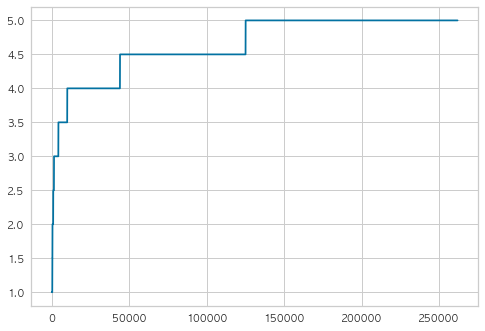

In [294]:
plt.plot(np.sort(rating['rating']))

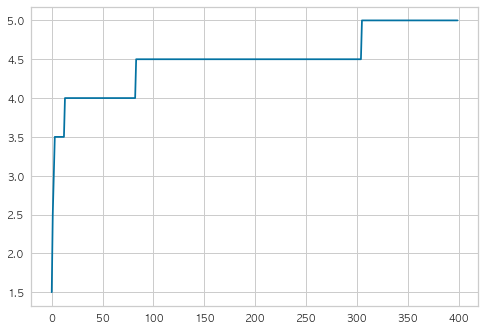

In [297]:
plt.plot(np.sort(rating.loc[rating['wine'] == 1835, 'rating']))

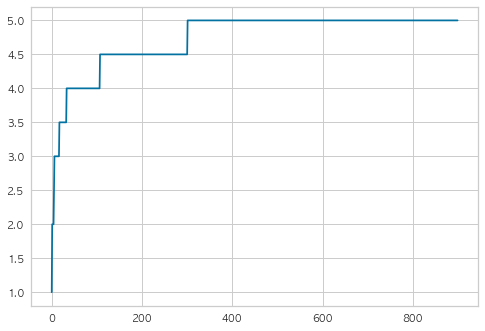

In [302]:
plt.plot(np.sort(rating.loc[rating['wine'] == 1684223, 'rating']))

In [68]:
piv = pd.pivot_table(rating, index = 'user', columns = 'wine', values = 'rating')

# 1. MF

In [80]:
# 출처 : https://yamalab.tistory.com/92?category=747907

class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """

        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """

        # init latent features
        self._P = np.random.normal(size=(self._num_users, self._k))
        self._Q = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_P = np.zeros(self._num_users)
        self._b_Q = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):

            # rating이 존재하는 index를 기준으로 training
            for i in range(self._num_users):
                for j in range(self._num_items):
                    if self._R[i, j] > 0:
                        self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """

        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        # 참고: http://codepractice.tistory.com/90
        xi, yi = self._R.nonzero()
        predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - predicted[x, y], 2)
        return np.sqrt(cost) / len(xi)


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD

        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """

        dp = (error * self._Q[j, :]) - (self._reg_param * self._P[i, :])
        dq = (error * self._P[i, :]) - (self._reg_param * self._Q[j, :])
        return dp, dq


    def gradient_descent(self, i, j, rating):
        """
        graident descent function

        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """

        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
        self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

        # update latent feature
        dp, dq = self.gradient(error, i, j)
        self._P[i, :] += self._learning_rate * dp
        self._Q[j, :] += self._learning_rate * dq


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix PXQ + P.bias + Q.bias + global bias

        - PXQ 행렬에 b_P[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_Q[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_P[:, np.newaxis] + self._b_Q[np.newaxis:, ] + self._P.dot(self._Q.T)


    def print_results(self):
        """
        print fit results
        """

        print("User Latent P:")
        print(self._P)
        print("Item Latent Q:")
        print(self._Q.T)
        print("P x Q:")
        print(self._P.dot(self._Q.T))
        print("bias:")
        print(self._b)
        print("User Latent bias:")
        print(self._b_P)
        print("Item Latent bias:")
        print(self._b_Q)
        print("Final R matrix:")
        R_reduced = self.get_complete_matrix()
        print(R_reduced)
        print("Final RMSE:")
        print(self._training_process[self._epochs-1][1])
        
        return R_reduced

In [82]:
piv

wine,1264,1651,1835,1869,2480,3547,3551,3553,3715,3908,...,6913339,7011222,7139566,7654487,7660568,7774865,8014725,8075591,8075594,8087753
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46828642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46874748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46886068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
factorizer = MatrixFactorization(np.array(piv.fillna(0)), k = 100, learning_rate = 0.01, reg_param = 0.01, epochs = 300, verbose = True)
factorizer.fit()
R_reduced = factorizer.print_results()

Iteration: 10 ; cost = 0.0010
Iteration: 20 ; cost = 0.0008
Iteration: 30 ; cost = 0.0007
Iteration: 40 ; cost = 0.0007
Iteration: 50 ; cost = 0.0006
Iteration: 60 ; cost = 0.0006
Iteration: 70 ; cost = 0.0005
Iteration: 80 ; cost = 0.0005
Iteration: 90 ; cost = 0.0005
Iteration: 100 ; cost = 0.0005
Iteration: 110 ; cost = 0.0004
Iteration: 120 ; cost = 0.0004
Iteration: 130 ; cost = 0.0004
Iteration: 140 ; cost = 0.0004
Iteration: 150 ; cost = 0.0004
Iteration: 160 ; cost = 0.0004
Iteration: 170 ; cost = 0.0004
Iteration: 180 ; cost = 0.0004
Iteration: 190 ; cost = 0.0003
Iteration: 200 ; cost = 0.0003
Iteration: 210 ; cost = 0.0003
Iteration: 220 ; cost = 0.0003
Iteration: 230 ; cost = 0.0003
Iteration: 240 ; cost = 0.0003
Iteration: 250 ; cost = 0.0003
Iteration: 260 ; cost = 0.0003
Iteration: 270 ; cost = 0.0003
Iteration: 280 ; cost = 0.0003
Iteration: 290 ; cost = 0.0003
Iteration: 300 ; cost = 0.0003
User Latent P:
[[-1.08550262  0.2283615   0.34358418 ...  1.96040288 -0.9445323

In [101]:
R = pd.DataFrame(R_reduced, index = piv.index, columns = piv.columns)

In [130]:
# 각 유저별 0~5점으로 정규화
norm_R = list(map(lambda x : (5 - 0) * ((x - min(x)) / (max(x) - min(x))), R.values))

In [133]:
norm_R = pd.DataFrame(norm_R, index = piv.index, columns = piv.columns)

In [141]:
# MF를 통해 user별 점수 예측 결과
norm_R

wine,1264,1651,1835,1869,2480,3547,3551,3553,3715,3908,...,6913339,7011222,7139566,7654487,7660568,7774865,8014725,8075591,8075594,8087753
user,,,,,,,,,,,,,,,,,,,,,
0,2.444488,2.287148,2.399868,2.394108,2.359355,2.274057,2.168631,2.045488,2.340480,2.423746,...,0.808767,2.219868,2.051748,1.265532,4.593671,2.448759,1.805465,2.518018,2.544304,2.009583
135,2.958220,3.143594,3.197277,2.927410,3.057204,3.528844,2.726899,2.792038,3.065418,3.160090,...,1.261426,3.193130,3.144389,0.693098,3.134428,2.589354,2.358565,4.098658,4.335793,1.951782
140,2.445149,2.566522,2.559987,2.552181,2.349041,2.696613,2.582357,2.387951,2.541916,2.685523,...,0.536264,2.325830,2.647549,2.452061,5.000000,2.478121,0.416770,2.128309,2.038967,2.046726
159,3.168122,3.144333,3.202647,3.066072,3.310643,2.543477,3.045715,3.566653,3.395279,3.235568,...,4.218281,3.280270,3.113679,1.722669,0.601057,3.166083,2.824441,4.623687,2.599087,2.705108
1201,1.955880,2.209166,1.833748,2.057175,2.339760,2.046302,2.286519,1.904740,2.335989,2.143789,...,0.787834,2.226018,2.494302,1.901058,0.000000,2.220281,2.498421,2.549607,1.727914,3.004347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46828642,2.900522,2.661466,2.615069,2.663207,2.804924,2.520086,2.463151,2.666727,2.442532,2.855805,...,2.139292,2.540796,2.827894,0.710556,2.196573,2.355833,3.083464,2.729761,1.625308,3.267832
46874748,2.478753,2.177306,1.761953,1.964874,1.852086,1.884076,1.873828,2.332677,2.348996,2.377719,...,5.000000,2.144360,2.179001,2.273411,3.992511,2.002807,4.518657,3.085482,1.365574,2.208094
46886068,2.419393,2.511066,2.537107,2.622304,2.725225,2.540280,2.391348,2.079530,2.553714,2.493750,...,1.067314,2.550150,2.612640,3.696391,3.958930,2.652853,2.566524,3.618886,3.407175,3.839911


In [158]:
norm_R.to_pickle('./norm_R_based_MF.pickle')

In [135]:
from sklearn.metrics.pairwise import cosine_similarity

In [136]:
CBF = pd.DataFrame(cosine_similarity(norm_R), index = piv.index, columns = piv.index)

In [137]:
# MF로 예측한 점수 기반 user간 코사인 유사도 결과
CBF

user,0,135,140,159,1201,2742,2764,2891,2954,2997,...,46787088,46792612,46794295,46795376,46819361,46828642,46874748,46886068,46895838,46950004
user,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.983711,0.977092,0.979182,0.966791,0.973716,0.975444,0.974558,0.971388,0.981787,...,0.974833,0.974376,0.974610,0.979473,0.982564,0.978479,0.963772,0.971948,0.975466,0.967717
135,0.983711,1.000000,0.980726,0.985671,0.975640,0.977045,0.976606,0.981192,0.973316,0.982256,...,0.980907,0.971820,0.984162,0.980350,0.988811,0.984553,0.967692,0.975958,0.981902,0.967174
140,0.977092,0.980726,1.000000,0.979558,0.972324,0.977175,0.980757,0.977719,0.974471,0.983795,...,0.976437,0.966204,0.979969,0.981578,0.985166,0.978786,0.961171,0.973498,0.976734,0.967081
159,0.979182,0.985671,0.979558,1.000000,0.973930,0.984632,0.979219,0.980711,0.982575,0.985733,...,0.981523,0.977328,0.989909,0.984370,0.990596,0.982274,0.973237,0.977053,0.982625,0.973875
1201,0.966791,0.975640,0.972324,0.973930,1.000000,0.967447,0.968404,0.968565,0.968073,0.971646,...,0.966501,0.956936,0.975757,0.967715,0.979109,0.973602,0.961872,0.965909,0.972575,0.963319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46828642,0.978479,0.984553,0.978786,0.982274,0.973602,0.979198,0.973382,0.974345,0.968210,0.979241,...,0.975970,0.963307,0.985032,0.979439,0.984567,1.000000,0.966585,0.972624,0.978762,0.963484
46874748,0.963772,0.967692,0.961171,0.973237,0.961872,0.968172,0.969860,0.959301,0.966165,0.967809,...,0.967912,0.962342,0.972209,0.969119,0.973842,0.966585,1.000000,0.956203,0.971553,0.959864
46886068,0.971948,0.975958,0.973498,0.977053,0.965909,0.974174,0.971722,0.970188,0.965108,0.978893,...,0.975705,0.968522,0.972447,0.977782,0.980259,0.972624,0.956203,1.000000,0.976756,0.962265


In [263]:
CBF.loc[0].nlargest(10)

user
0           1.000000
39278485    0.988790
17326880    0.987720
341731      0.987625
4567291     0.987383
3055245     0.987072
1664709     0.987006
33307896    0.986938
329667      0.986936
9034371     0.986905
Name: 0, dtype: float64

In [264]:
CBF.loc[1201].nlargest(10)

user
1201        1.000000
15626800    0.986045
3382263     0.984062
2390484     0.983842
3000064     0.983833
10858902    0.983644
43278145    0.983596
2169055     0.983494
1925152     0.983493
23618593    0.983229
Name: 1201, dtype: float64

In [142]:
# MF로 예측한 점수 기반 군집 분석

In [143]:
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

In [146]:
# 각 군집 수에 따른 SSE(군집내 오차제곱합)와 Silhouette score(군집간 분리도 - 군집내 응집도) 계산하여 리스트로 저장
wss = []
sis = []

for k in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(norm_R)
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(norm_R, kmeans.labels_))

100%|██████████| 8/8 [08:36<00:00, 64.61s/it]


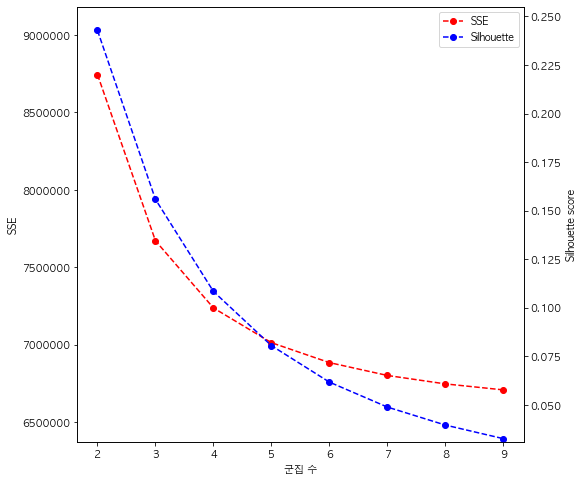

In [151]:
# 군집 수에 따른 SSE와 Silhouette score 시각화

fig, ax1 = plt.subplots(figsize = (8,8))
ax2 = ax1.twinx() # 양쪽 축을 개별로 사용

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show()

In [153]:
import warnings
warnings.filterwarnings(action='ignore') # 경고창 없애기

from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer

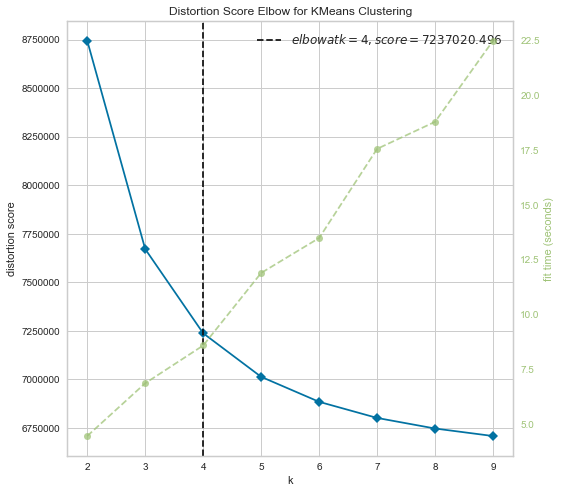

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fecea5d3fd0>,
                 k=None, model=None)

In [155]:
plt.figure(figsize = (8,8))
kelbow_visualizer(KMeans(random_state=0), norm_R, k=(2,10))

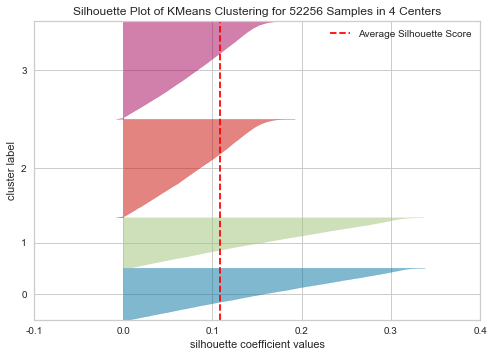

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7feceaccc0d0>,
                     colors='yellowbrick', model=None)

In [157]:
# 군집이 4개일 때, 실루엣 계수의 평균은 0.2
# 모든 군집이 실루엣 계수를 어느정도 초과했지만, 실루엣 계수 자체가 약간 낮음
silhouette_visualizer(KMeans(4, random_state=0), norm_R, colors='yellowbrick')

In [160]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(norm_R)

KMeans(n_clusters=4, random_state=0)

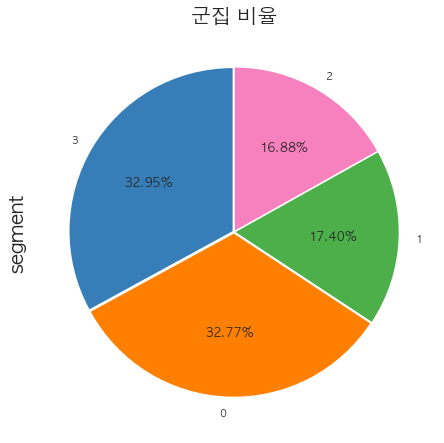

In [168]:
plt.figure(figsize=(7,7))
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf']
explode = [0.01 for j in range(best_k)]
pd.Series(kmeans.labels_).value_counts().plot.pie(autopct='%.2f%%', figsize=(6,6), startangle=90, legend=False, explode = explode, colors = colors)
plt.title("군집 비율", fontsize = 20)
plt.ylabel('segment', fontsize = 20)
plt.tight_layout(pad=0.1, h_pad=0.1)
plt.show()

In [182]:
segment = pd.DataFrame(list(zip(norm_R.index, kmeans.labels_)), columns = ['user', 'segment'])

In [198]:
norm_R.loc[segment.loc[segment['segment'] == 0, 'user']].mean().nlargest(10)

wine
8087753    2.457375
7660568    2.456417
6913339    2.446570
6005900    2.432534
2014198    2.431253
83913      2.415312
83911      2.414195
1654616    2.413721
5089513    2.408484
1884484    2.407541
dtype: float64

In [199]:
norm_R.loc[segment.loc[segment['segment'] == 1, 'user']].mean().nlargest(10)

wine
82061      3.194839
83911      3.190116
1271002    3.187170
2344981    3.178999
8075594    3.175642
83920      3.162701
82199      3.158552
83913      3.158292
13563      3.156282
1174525    3.154565
dtype: float64

In [200]:
norm_R.loc[segment.loc[segment['segment'] == 2, 'user']].mean().nlargest(10)

wine
8087753    2.353919
6913339    2.312014
6005900    2.309494
2014198    2.299701
7660568    2.287317
5089513    2.194996
4294117    2.184112
3778314    2.165650
5420759    2.133783
4210061    2.114825
dtype: float64

In [201]:
norm_R.loc[segment.loc[segment['segment'] == 3, 'user']].mean().nlargest(10)

wine
83911      2.774254
1271002    2.762829
83913      2.760106
83920      2.754685
82061      2.749755
83912      2.745953
87552      2.744723
13563      2.743755
2446729    2.741697
1911534    2.741344
dtype: float64

# user-wine 리뷰

In [206]:
file.keys()

dict_keys(['wine_id', 'vintage_id', 'vintage_type', 'vintage_year', 'userID', 'rating_per_user', 'user_note', 'user_follower_count', 'user_following_count', 'user_rating_count', 'user_rating_sum', 'reviews_count', 'user_like_count', 'user_comments_count', 'review_time', 'review_language', 'review_year'])

In [215]:
review = pd.DataFrame(list(zip(file['userID'].values(), file['wine_id'].values(), file['user_note'].values())), columns = ['user', 'wine', 'review'])

In [223]:
import re

In [229]:
review['review'].fillna('').apply(lambda x : re.sub(r'[\w-][\n]+@\t\s[\w.]', '', x))

0                    Another good amarone. Need I say more?
1         Incredible wine, much unlike the '06 this has ...
2         Lovely amarone, silky tannins, dried fruit, mi...
3         Love the dried fruit juice.  Really takes you ...
4         No need for introductions here. A big wine fro...
                                ...                        
261971    (4,0) Smoother, ripened tannins. Lush fruit. F...
261972    🍷👀 djupröd, begynnande tegel i kanten \n👃🏼 lit...
261973    Cereja negra, um dos melhores vinho que já exp...
261974                                             Amazing 
261975                                                 4.5+
Name: review, Length: 261976, dtype: object

# wine taste 군집

In [231]:
taste = pd.read_csv('taste_v2_813.csv')

In [235]:
taste = taste.sort_values('Unnamed: 0').rename(columns = {'Unnamed: 0' : 'wine'})

In [238]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [240]:
taste.index = taste['wine']
taste = taste.drop('wine', axis = 1)

In [245]:
X = pd.DataFrame(scaler.fit_transform(taste), columns = taste.columns, index = taste.index)

In [248]:
X = X.fillna(0)

In [249]:
# 각 군집 수에 따른 SSE(군집내 오차제곱합)와 Silhouette score(군집간 분리도 - 군집내 응집도) 계산하여 리스트로 저장
wss = []
sis = []

for k in tqdm(range(2,10)):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(X)
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(X, kmeans.labels_))

100%|██████████| 8/8 [00:00<00:00, 12.11it/s]


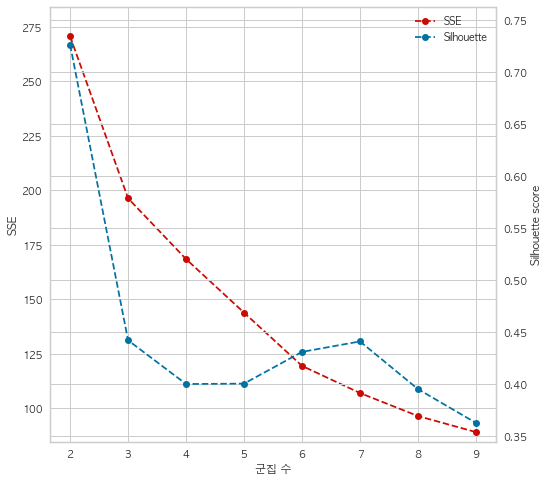

In [250]:
# 군집 수에 따른 SSE와 Silhouette score 시각화

fig, ax1 = plt.subplots(figsize = (8,8))
ax2 = ax1.twinx() # 양쪽 축을 개별로 사용

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show()

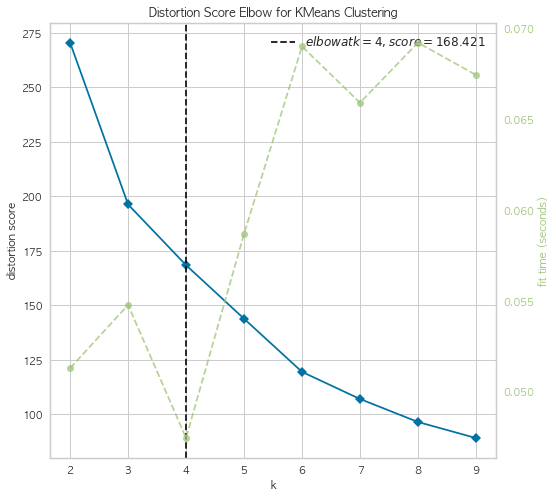

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fed07f8eb10>,
                 k=None, model=None)

In [251]:
plt.figure(figsize = (8,8))
kelbow_visualizer(KMeans(random_state=0), X, k=(2,10))

In [252]:
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=0)

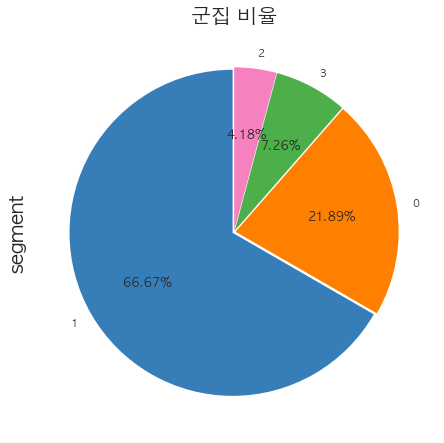

In [253]:
plt.figure(figsize=(7,7))
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf']
explode = [0.01 for j in range(best_k)]
pd.Series(kmeans.labels_).value_counts().plot.pie(autopct='%.2f%%', figsize=(6,6), startangle=90, legend=False, explode = explode, colors = colors)
plt.title("군집 비율", fontsize = 20)
plt.ylabel('segment', fontsize = 20)
plt.tight_layout(pad=0.1, h_pad=0.1)
plt.show()

In [256]:
X

,oak_count,oak_score,oak_mentions_count,black_fruit_count,black_fruit_score,black_fruit_mentions_count,earth_count,earth_score,earth_mentions_count,red_fruit_count,...,acidity,fizziness,intensity,sweetness,tannin,user_structure_count,calculated_structure_count,tropical_fruit_count,tropical_fruit_score,tropical_fruit_mentions_count
wine,,,,,,,,,,,,,,,,,,,,,
1264,0.105209,0.107543,0.108830,0.112523,0.125204,0.122456,0.103023,0.080656,0.075859,0.036426,...,0.564305,0.0,0.554468,0.267395,0.619513,0.048539,0.058198,0.000000,0.021845,0.032258
1651,0.247531,0.229670,0.234232,0.255445,0.283834,0.279279,0.372610,0.354201,0.347514,0.164485,...,0.464386,0.0,0.299115,0.334449,0.420910,0.475495,0.134680,0.153846,0.064884,0.032258
1835,0.116786,0.108372,0.109077,0.102087,0.079546,0.077744,0.160395,0.132887,0.129165,0.116107,...,0.231862,0.0,0.846976,0.801317,0.196412,0.136664,0.081740,0.000000,0.000000,0.000000
1869,0.126319,0.119194,0.119218,0.162432,0.172409,0.170838,0.152375,0.123498,0.121476,0.109277,...,0.344109,0.0,0.564825,0.400311,0.270371,0.791235,0.107075,0.000000,0.021845,0.032258
2480,0.002383,0.002178,0.002226,0.000454,0.000103,0.000000,0.000617,0.001372,0.001025,0.000000,...,0.296981,0.0,0.524333,0.311857,0.215592,0.012724,0.000598,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7774865,0.013279,0.016905,0.016325,0.016334,0.016111,0.015682,0.014806,0.012034,0.013326,0.007399,...,0.455659,0.0,0.903043,0.355957,0.543763,0.019321,0.005617,0.000000,0.000000,0.000000
8014725,0.000000,0.000465,0.000495,0.000000,0.000000,0.000000,0.000617,0.001027,0.001025,0.000569,...,0.699358,0.0,0.225907,0.425275,0.681168,0.001414,0.000478,0.000000,0.000000,0.000000
8075591,0.001362,0.001542,0.001484,0.001361,0.001137,0.001001,0.000617,0.000787,0.001025,0.001138,...,0.754039,0.0,0.870246,0.480431,0.734756,0.001414,0.000956,0.000000,0.000000,0.000000


In [275]:
# user

In [277]:
file.keys()

dict_keys(['wine_id', 'vintage_id', 'vintage_type', 'vintage_year', 'userID', 'rating_per_user', 'user_note', 'user_follower_count', 'user_following_count', 'user_rating_count', 'user_rating_sum', 'reviews_count', 'user_like_count', 'user_comments_count', 'review_time', 'review_language', 'review_year'])

In [276]:
pd.DataFrame(list(zip(file['userID'].values(), file['user_rating_count'].values()))).drop_duplicates(0)

,0,1
0,12287760,352.0
1,579752,2460.0
2,965583,436.0
3,20880779,315.0
4,24068906,89.0
...,...,...
261912,36947246,6.0
261917,44802322,50.0
261932,41198685,9.0
261967,26702188,85.0


In [280]:
pd.DataFrame(list(zip(file['userID'].values(), file['user_like_count'].values()))).drop_duplicates(0)

,0,1
0,12287760,1.0
1,579752,7.0
2,965583,23.0
3,20880779,2.0
4,24068906,2.0
...,...,...
261912,36947246,0.0
261917,44802322,2.0
261932,41198685,0.0
261967,26702188,1.0


In [312]:
t = pd.DataFrame(list(zip(file['userID'].values(), file['user_note'].values(), file['review_time'].values()))).drop_duplicates()

In [316]:
t

,0,1,2
0,12287760,Another good amarone. Need I say more?,2019-04-20T22:56:53.000Z
1,579752,"Incredible wine, much unlike the '06 this has ...",2017-03-31T16:18:30.000Z
2,965583,"Lovely amarone, silky tannins, dried fruit, mi...",2016-07-06T10:50:53.000Z
3,20880779,Love the dried fruit juice. Really takes you ...,2019-08-30T18:37:36.000Z
4,24068906,No need for introductions here. A big wine fro...,2017-08-13T23:15:04.000Z
...,...,...,...
261971,5293486,"(4,0) Smoother, ripened tannins. Lush fruit. F...",2020-06-07T11:58:25.000Z
261972,2483751,"🍷👀 djupröd, begynnande tegel i kanten \n👃🏼 lit...",2020-09-25T15:14:25.000Z
261973,37249519,"Cereja negra, um dos melhores vinho que já exp...",2020-07-11T21:50:26.000Z
261974,43215761,Amazing,2020-10-04T09:48:08.000Z


In [324]:
file.keys()

dict_keys(['wine_id', 'vintage_id', 'vintage_type', 'vintage_year', 'userID', 'rating_per_user', 'user_note', 'user_follower_count', 'user_following_count', 'user_rating_count', 'user_rating_sum', 'reviews_count', 'user_like_count', 'user_comments_count', 'review_time', 'review_language', 'review_year'])

In [318]:
pd.DataFrame(list(zip(file['userID'].values(), file['user_note'].values(), file['review_time'].values())))

,0,1,2
0,12287760,Another good amarone. Need I say more?,2019-04-20T22:56:53.000Z
1,579752,"Incredible wine, much unlike the '06 this has ...",2017-03-31T16:18:30.000Z
2,965583,"Lovely amarone, silky tannins, dried fruit, mi...",2016-07-06T10:50:53.000Z
3,20880779,Love the dried fruit juice. Really takes you ...,2019-08-30T18:37:36.000Z
4,24068906,No need for introductions here. A big wine fro...,2017-08-13T23:15:04.000Z
...,...,...,...
261971,5293486,"(4,0) Smoother, ripened tannins. Lush fruit. F...",2020-06-07T11:58:25.000Z
261972,2483751,"🍷👀 djupröd, begynnande tegel i kanten \n👃🏼 lit...",2020-09-25T15:14:25.000Z
261973,37249519,"Cereja negra, um dos melhores vinho que já exp...",2020-07-11T21:50:26.000Z
261974,43215761,Amazing,2020-10-04T09:48:08.000Z
